In [4]:
# !which python
# !pip show torch
!pip show transformers

Name: transformers
Version: 4.28.0.dev0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/harishbabu/.conda/envs/ferret/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, tokenizers, tqdm
Required-by: ferret, peft


In [3]:
import sys
print(sys.executable)
print(sys.path)

sys.path.insert(0, '/home/harishbabu/.conda/envs/ferret/lib/python3.10')

print(sys.path)

/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/bin/python3
['/home/harishbabu/projects/ml-ferret', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python38.zip', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python3.8', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python3.8/lib-dynload', '', '/home/harishbabu/.local/lib/python3.8/site-packages', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python3.8/site-packages', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python3.8/site-packages/IPython/extensions', '/home/harishbabu/.ipython']
['/home/harishbabu/.conda/envs/ferret/lib/python3.10', '/home/harishbabu/projects/ml-ferret', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python38.zip', '/apps/easybuild/software/tinkercliffs-rome_dgx-a100/Anaconda3/2020.11/lib/python3.8', '/apps/easybuild/softw

In [5]:
import argparse
from typing import Any, Tuple
import torch
import os
import json
from tqdm import tqdm

# Added
from ferret.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria
from ferret.model.builder import load_pretrained_model
from ferret.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from ferret.conversation import conv_templates, SeparatorStyle
from ferret.utils import disable_torch_init
from PIL import Image
import re
import math
import torchvision
import numpy as np
from copy import deepcopy

# Added for visualization
from PIL import Image, ImageDraw, ImageFont

ModuleNotFoundError: No module named 'transformers'

In [17]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--model-path", type=str, default="facebook/opt-350m")
# parser.add_argument("--model-base", type=str, default=None)
# parser.add_argument("--image_path", type=str, default="data/refcoco/train2014")
# parser.add_argument("--data_path", type=str, default="data/annotations/finetune_refcoco_testA.json")
# parser.add_argument("--answers-file", type=str, default="refexp_result/refcoco_testA")
# parser.add_argument("--conv-mode", type=str, default="ferret_v1")
# parser.add_argument("--num-chunks", type=int, default=1)
# parser.add_argument("--chunk-idx", type=int, default=0)
# parser.add_argument("--image_w", type=int, default=336)  #  224
# parser.add_argument("--image_h", type=int, default=336)  #  224
# parser.add_argument("--add_region_feature", action="store_true")
# parser.add_argument("--temperature", type=float, default=0.001)
# parser.add_argument("--top_p", type=float, default=None)
# parser.add_argument("--num_beams", type=int, default=1)
# args = parser.parse_args()

class Args:
    
    def __init__(self):
        self.model_path = "facebook/opt-350m"
        self.model_base = None
        self.image_path = "data/refcoco/train2014"
        self.data_path = "data/annotations/finetune_refcoco_testA.json"
        self.answers_file = "refexp_result/refcoco_testA"
        self.conv_mode = "ferret_v1"
        self.num_chunks = 1
        self.chunk_idx = 0
        self.image_w = 336  #  224
        self.image_h = 336  #  224
        self.add_region_feature = True
        self.temperature = 0.001
        self.top_p = None
        self.num_beams = 1
        
args = Args()

In [30]:
args.model_path = "model/ferret-7b-v1-3/"

# Model
disable_torch_init()
model_path = os.path.expanduser(args.model_path)
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, args.model_base, model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
Some weights of the model checkpoint at openai/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.6.layer_norm2.bias', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.4.self_attn.k_proj.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.10.mlp.fc2.bias', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.9.layer_norm2.bias', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.9.layer_norm1.weight', 'text_model.encoder.layers.9.layer_norm2.weight', 'text_model.encoder.layers.5.layer_norm2.weight', 'text_model.encoder.layers.2.self_attn.k_proj.bias', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.3.self_attn.k_pro

In [29]:
# from ferret.model import *
# kwargs = {"device_map": "auto"}
# kwargs['torch_dtype'] = torch.float16
# model_path = "_"
# FERRETLlamaForCausalLM.from_pretrained(model_path, low_cpu_mem_usage=True, **kwargs)

In [35]:
model.config.mm_use_im_start_end

False

In [33]:
img = Image.open('dump/giraffe.jpg')

In [34]:
img.size

(640, 480)

In [54]:
qs = "Where is giraffe in this image?"

if model.config.mm_use_im_start_end:
    qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
else:
    qs = DEFAULT_IMAGE_TOKEN + '\n' + qs
            
conv = conv_templates[args.conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()
input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()
img_w, img_h = img.size # ann["img_w"], ann["img_h"]
image_tensor = image_processor.preprocess(img, return_tensors='pt', do_resize=True, 
                                          do_center_crop=False, size=[args.image_h, args.image_w])['pixel_values'][0]
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
keywords = [stop_str]
stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

In [55]:
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=image_tensor.unsqueeze(0).half().cuda(),
        do_sample=True,
        temperature=args.temperature,
        top_p=args.top_p,
        num_beams=args.num_beams,
        # no_repeat_ngram_size=3,
        max_new_tokens=1024,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
        )

In [56]:
input_token_len = input_ids.shape[1]
n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
if n_diff_input_output > 0:
    print(f'[Warning] Sample {i}: {n_diff_input_output} output_ids are not the same as the input_ids')
outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
outputs = outputs.strip()
if outputs.endswith(stop_str):
    outputs = outputs[:-len(stop_str)]
outputs = outputs.strip()

In [57]:
outputs

'giraffe in this image [441, 179, 758, 745].'

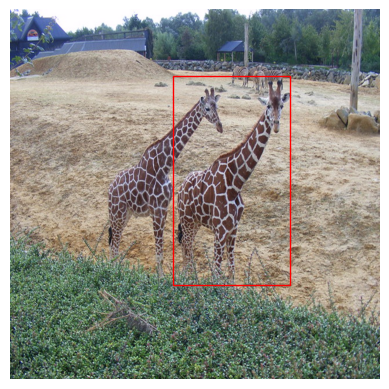

In [58]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_bounding_box(image, bbox):
    fig, ax = plt.subplots()
    ax.imshow(image)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.axis('off')
    plt.show()
    
plot_bounding_box(img.resize((1000, 1000)), bbox=[441, 179, 758, 745])